In [1]:
import iris
import matplotlib.pyplot as plt
import iris.plot as iplt
import sys, os
import glob

# Import my modules

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)

import convenient_universal as uconv
import timeseries
import general_io as gio

import warnings
warnings.filterwarnings('ignore')

In [2]:
area_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Ofx/areacello/gn/v20191108/areacello_Ofx_ACCESS-CM2_historical_r1i1p1f1_gn.nc'
area_cube = iris.load_cube(area_file, 'cell_area')

In [3]:
var_dict = {}
var_dict['hflux-coupler'] = 'surface heat flux coming through coupler'
var_dict['hflux-runoff'] = 'temperature_flux_due_to_runoff_expressed_as_heat_flux_into_sea_water'
var_dict['hflux-pme'] = 'heat flux (relative to 0C) from pme transfer of water across ocean surface'
var_dict['hflux-net'] = 'surface ocean heat flux coming through coupler and mass transfer'
var_dict['hflux-correct'] = 'heat_flux_correction'
var_dict['hflux-restore'] = 'surface heat flux from restoring'
var_dict['hfds'] = 'surface_downward_heat_flux_in_sea_water'

var_dict['pme-net'] = "precip-evap into ocean (total w/ restore + normalize)"
var_dict['pme-sbc'] = 'precip-evap via sbc (liquid, frozen, evaporation)'
var_dict['pme-correct'] = 'precip-evap from flux correction (>0 enters ocean)'
var_dict['runoff'] = 'water_flux_into_sea_water_from_rivers'
var_dict['temp-tendency'] = 'rho*dzt*cp*heating due to increment'
var_dict['wfo'] = 'water_flux_into_sea_water'

def get_files(experiment):
    """Get the files"""
    
    assert experiment in ['faf-heat', 'faf-water']

    file_dict = {}
    file_dict['hflux-coupler'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-coupler/gn/v20191210/sfc-hflux-coupler_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-runoff'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-from-runoff/gn/v20191210/sfc-hflux-from-runoff_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-pme'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-pme/gn/v20191210/sfc-hflux-pme_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-net'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/net-sfc-heating/gn/v20191210/net-sfc-heating_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-correct'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-correct/gn/v20191210/sfc-hflux-correct_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['hflux-restore'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/sfc-hflux-restore/gn/v20191210/sfc-hflux-restore_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['temp-tendency'] = glob.glob(f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Emon/temp-increment-tend/gn/v20191210/temp-increment-tend_Emon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_*.nc')
    file_dict['temp-tendency'].sort()
    file_dict['hfds'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/hfds/gn/v20191210/hfds_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'

    file_dict['pme-net'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/pme-net/gn/v20191210/pme-net_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['pme-sbc'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/pme-sbc/gn/v20191210/pme-sbc_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['pme-correct'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/pme-correct/gn/v20191210/pme-correct_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['runoff'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/runoff/gn/v20191210/runoff_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'
    file_dict['wfo'] = f'/g/data/r87/dbi599/CMIP6/FAFMIP/KEWEI-LYU/ACCESS-OM2/{experiment}/r1i1p1f1/Omon/wfo/gn/v20191210/wfo_Omon_ACCESS-OM2_{experiment}_r1i1p1f1_gn_095001-101912.nc'

    return file_dict

In [4]:
def get_cubes(file_dict):
    """Get cubes"""

    cube_dict = {}
    for var in ['hflux-coupler', 'hflux-runoff', 'hflux-pme', 'hflux-net',
                'hflux-correct', 'hflux-restore', 'hfds',
                'pme-net', 'pme-sbc', 'pme-correct', 'runoff', 'wfo']:
        cube = iris.load_cube(file_dict[var], var_dict[var])
        assert cube.units in ['W m-2', 'kg m-2 s-1']
        out_units = 'W' if cube.units == 'W m-2' else 'kg s-1'
        cube = cube * uconv.broadcast_array(area_cube.data, [1, 2], cube.shape)
        coord_names = [coord.name() for coord in cube.dim_coords]
        gs_cube = cube.collapsed(coord_names[1:], iris.analysis.SUM)
        gs_cube = timeseries.convert_to_annual(gs_cube, aggregation='sum')
        gs_cube.units = out_units
        cube_dict[var] = gs_cube
    
    cube_list = iris.cube.CubeList([])
    for tendency_file in file_dict['temp-tendency']:
        cube = iris.load_cube(tendency_file, var_dict['temp-tendency'])
        ntimes = cube.shape[0]
        cube = cube * uconv.broadcast_array(area_cube.data, [2, 3], cube.shape)
        coord_names = [coord.name() for coord in cube.dim_coords]
        gs_cube = cube.collapsed(coord_names[1:], iris.analysis.SUM)
        gs_cube = timeseries.convert_to_annual(gs_cube, aggregation='sum')
        gs_cube.units = 'W'
        cube_list.append(gs_cube)
    cube_dict['temp-tendency'] = gio.combine_cubes(cube_list)
                
    return cube_dict

In [12]:
def plot_heat(experiment):

    file_dict = get_files(experiment)
    cube_dict = get_cubes(file_dict)
    surface_area = 5.1e14
    
    coupler_data = cube_dict['hflux-coupler'].data / surface_area
    plt.plot(coupler_data, label='coupler', linestyle=':')
    print(f'hflux-coupler: {coupler_data[0]} W m-2')
    
    runoff_data = cube_dict['hflux-runoff'].data / surface_area
    plt.plot(runoff_data, label='runoff', linestyle=':')
    print(f'hflux-runoff: {runoff_data[0]} W m-2')
    
    pme_data = cube_dict['hflux-pme'].data / surface_area
    plt.plot(pme_data, label='pme', linestyle=':')
    print(f'hflux-pme: {pme_data[0]} W m-2')
    
    tendency_data = cube_dict['temp-tendency'].data / surface_area
    plt.plot(tendency_data, label='temp-tendency', linestyle=':')
    print(f'temp-tendency: {tendency_data[0]} W m-2')
    
    net_data = cube_dict['hflux-net'].data / surface_area
    plt.plot(net_data, label='net', linestyle='--')
    print(f'hflux-net: {net_data[0]} W m-2')
    
    restore_data = cube_dict['hflux-restore'].data / surface_area
    plt.plot(restore_data, label='restoring', linestyle=':')
    print(f'hflux-restore: {restore_data[0]} W m-2')
    
    correct_data = cube_dict['hflux-correct'].data / surface_area
    plt.plot(correct_data, label='correction', linestyle=':')
    print(f'hflux-correct: {correct_data[0]} W m-2')
    
    hfds_data = cube_dict['hfds'].data / surface_area
    plt.plot(hfds_data, label='hfds')
    print(f'hfds: {hfds_data[0]} W m-2')

    alt_hfds_data = coupler_data + runoff_data + pme_data + correct_data + tendency_data
    plt.plot(alt_hfds_data, label='alternative hfds')
    print(f'alternative hfds: {alt_hfds_data[0]} W m-2')
    
    plt.ylabel(f"{cube_dict['hfds'].units} m-2")
    plt.xlabel('year')
    plt.title(f'Total (global) annual heat flux, {experiment}')
    plt.legend()
    plt.show()

In [9]:
def plot_water(experiment):

    file_dict = get_files(experiment)
    cube_dict = get_cubes(file_dict)

    net_data = cube_dict['pme-net'].data
    plt.plot(net_data, label='pme-net', linestyle='--')
    print(f'pme-net: {net_data[0]} kg s-1')
    
    runoff_data = cube_dict['runoff'].data
    plt.plot(runoff_data, label='runoff', linestyle=':')
    print(f'runoff: {runoff_data[0]} kg s-1')
    
    #plt.plot(cube_dict['pme-correct'].data, label='pme-correct', linestyle=':')
    #plt.plot(cube_dict['pme-sbc'].data, label='pme-sbc', linestyle=':')
    
    wfo_data = cube_dict['wfo'].data
    plt.plot(wfo_data, label='wfo')
    print(f'wfo: {wfo_data[0]} kg s-1')
    
    plt.ylabel(cube_dict['wfo'].units)
    plt.xlabel('year')
    plt.title(f'Total (global) annual freshwater flux, {experiment}')
    plt.legend()
    plt.show()

hflux-coupler: 1.694119930267334 W m-2
hflux-runoff: 2.233888864517212 W m-2
hflux-pme: -4.393278121948242 W m-2
temp-tendency: 1.1789501905441284 W m-2
hflux-net: -0.5280888676643372 W m-2
hflux-restore: 2.611294803500641e-05 W m-2
hflux-correct: 16.107500076293945 W m-2
hfds: 15.64222526550293 W m-2
alternative hfds: 16.82118034362793 W m-2


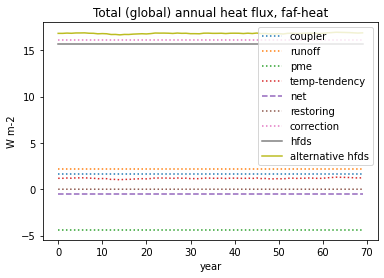

In [13]:
plot_heat('faf-heat')

In [14]:
1.694119930267334 + 2.233888864517212 - 4.393278121948242

-0.4652693271636963

hflux-coupler: 1.694119930267334 W m-2
hflux-runoff: 2.233888864517212 W m-2
hflux-pme: -4.670576572418213 W m-2
temp-tendency: 1.1789501905441284 W m-2
hflux-net: -0.5280888676643372 W m-2
hflux-restore: 2.611294803500641e-05 W m-2
hflux-correct: 0.0 W m-2
hfds: -0.7425719499588013 W m-2
alternative hfds: 0.4363824129104614 W m-2


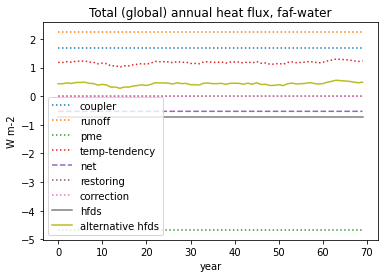

In [15]:
plot_heat('faf-water')

pme-net: -15265384448.0 kg s-1
runoff: 15355448320.0 kg s-1
wfo: 90064960.0 kg s-1


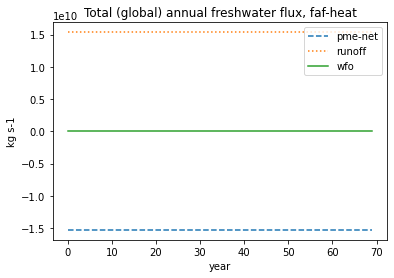

In [68]:
plot_water('faf-heat')

pme-net: -15105673216.0 kg s-1
runoff: 15355448320.0 kg s-1
wfo: 249773856.0 kg s-1


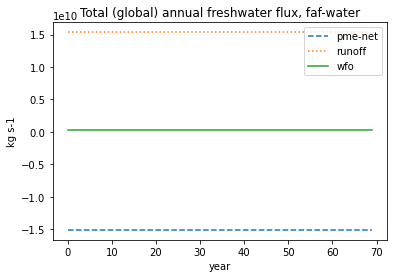

In [69]:
plot_water('faf-water')